<a href="https://colab.research.google.com/github/SridharaniKatipally/Diabetes-prediction-using-ML/blob/main/diabetes(new).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Load the dataset
file_path = '/content/Dataset of Diabetes .csv'
data = pd.read_csv(file_path)

In [18]:
data.head()


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [19]:
# Encode categorical variables
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['CLASS'] = label_encoder.fit_transform(data['CLASS'])

In [20]:
# Define features and target variable
X = data.drop(['ID', 'No_Pation', 'CLASS'], axis=1)
y = data['CLASS']


In [21]:
# Check the class distribution
class_counts = y.value_counts()
print(class_counts)

CLASS
3    840
0    102
2     53
4      4
1      1
Name: count, dtype: int64


In [24]:
# Remove the extremely small class
data = data[y != 1]
X = data.drop(['ID', 'No_Pation', 'CLASS'], axis=1)
y = data['CLASS']

In [25]:
# Check the class distribution again
class_counts = y.value_counts()
print(class_counts)


CLASS
3    840
0    102
2     53
4      4
Name: count, dtype: int64


In [26]:
# Handle class imbalance with SMOTE (with adjusted k_neighbors) and RandomUnderSampler
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, y_smote = smote.fit_resample(X, y)

under = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under.fit_resample(X_smote, y_smote)


In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [28]:
# Normalize/Standardize continuous features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
# Initialize and train the Random Forest model with StratifiedKFold
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
strat_kfold = StratifiedKFold(n_splits=3)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=strat_kfold, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [30]:
# Best model
best_rf = grid_search.best_estimator_

In [31]:
# Predictions
y_pred = best_rf.predict(X_test)
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

In [36]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9940476190476191
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       193
           2       1.00      1.00      1.00       164
           3       1.00      0.97      0.99       160
           4       0.99      1.00      0.99       155

    accuracy                           0.99       672
   macro avg       0.99      0.99      0.99       672
weighted avg       0.99      0.99      0.99       672



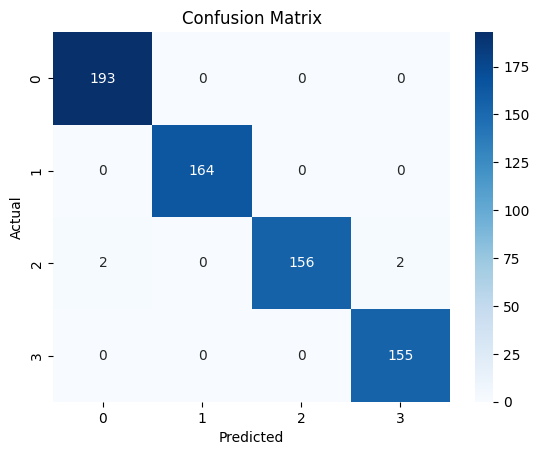

In [37]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Feature Importance
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

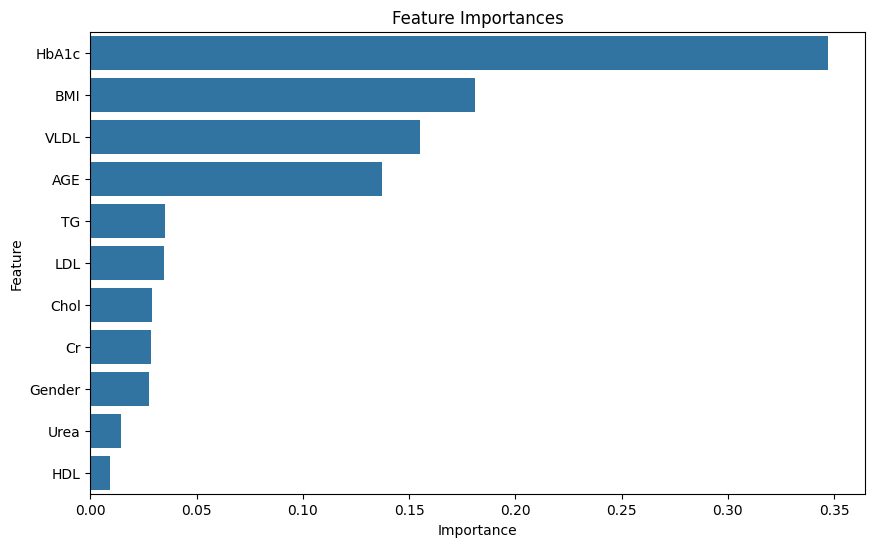

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()